In [242]:
import json
import requests

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error

sns.set_palette('Set2')
%matplotlib inline

In [243]:
hist = pd.read_csv('COVID-CASES.csv')
hist = hist.set_index('Date')

In [244]:
hist.head()

,cases,deaths,recovered
Date,,,
1/22/20,555,17,28
1/23/20,654,18,30
1/24/20,941,26,36
1/25/20,1434,42,39
1/26/20,2118,56,52


In [245]:
target_col = 'cases'

In [246]:
def train_test_split(df, test_size=0.1):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [247]:
train, test = train_test_split(hist, test_size=0.1)

## Plot data

In [248]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.set_facecolor('#00000000')
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('COVID-19 Cases (In Millions)', fontsize=14)
    ax.set_xlabel('Dates', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18);
    ax.xaxis.set_major_locator(plt.MaxNLocator(15))
    #ax.ticklabel_format(useOffset=False, style='plain')

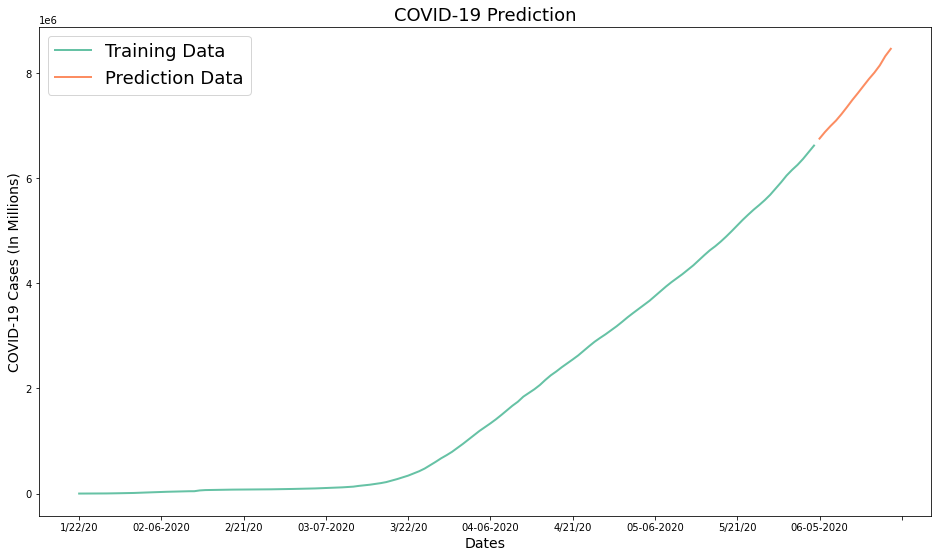

In [249]:
line_plot(train[target_col], test[target_col], 'Training Data', 'Prediction Data', title='COVID-19 Prediction')

## LSTM

In [250]:
def normalise_zero_base(df):
    """ Normalise dataframe column-wise to reflect changes with respect to first entry. """
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    """ Normalise dataframe column-wise min/max. """
    return (df - df.min()) / (data.max() - df.min())

In [251]:
def extract_window_data(df, window_len=10, zero_base=True):
    """ Convert dataframe to overlapping sequences/windows of len `window_data`.
    
        :param window_len: Size of window
        :param zero_base: If True, the data in each window is normalised to reflect changes
            with respect to the first entry in the window (which is then always 0)
    """
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [252]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    """ Prepare data for LSTM. """
    # train test split
    train_data, test_data = train_test_split(df, test_size=test_size)
    
    # extract window data
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    
    # extract targets
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [253]:
def build_lstm_model(input_data, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [254]:
np.random.seed(42)

# data params
window_len = 7
test_size = 0.1
zero_base = True

# model params
lstm_neurons = 20
epochs = 50
batch_size = 2
loss = 'mae'
dropout = 0.25
optimizer = 'adam'

In [255]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [256]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
128/128 [==============================] - 0s 4ms/step - loss: 0.6282
Epoch 2/50
128/128 [==============================] - 0s 2ms/step - loss: 0.5226
Epoch 3/50
128/128 [==============================] - 0s 2ms/step - loss: 0.4350
Epoch 4/50
128/128 [==============================] - 0s 2ms/step - loss: 0.3980
Epoch 5/50
128/128 [==============================] - 0s 2ms/step - loss: 0.3189
Epoch 6/50
128/128 [==============================] - 0s 2ms/step - loss: 0.3020
Epoch 7/50
128/128 [==============================] - 0s 2ms/step - loss: 0.2807
Epoch 8/50
128/128 [==============================] - 0s 2ms/step - loss: 0.2739
Epoch 9/50
128/128 [==============================] - 0s 2ms/step - loss: 0.2249
Epoch 10/50
128/128 [==============================] - 0s 2ms/step - loss: 0.2123
Epoch 11/50
128/128 [==============================] - 0s 2ms/step - loss: 0.2384
Epoch 12/50
128/128 [==============================] - 0s 2ms/step - loss: 0.2018
Epoch 13/50
128/128 [====

## Plot predictions

In [257]:

from keras.models import load_model
import cv2
import numpy as np

In [258]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()

In [259]:
mean_absolute_error(preds, y_test)

0.01690599264514498

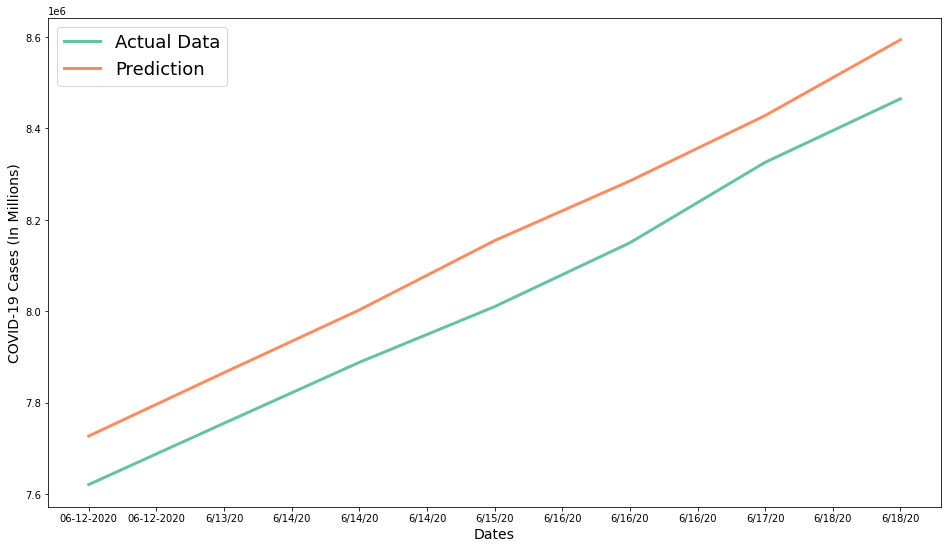

In [260]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)

line_plot(targets, preds, 'Actual Data', 'Prediction', lw=3)